<a href="https://colab.research.google.com/github/sharmita01/Coursework_projects/blob/main/ResNets_and_LR_Scheduling_Dey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3 - CNNs, ResNets and LR-Scheduling

## General information
* Deep Learning – Winter term 2020/21
* Instructor: Alexander Ecker
* Tutors: Max Burg, Laura Pede
* Teaching assistants: Clara Holzhüter, Pronaya Prosun Das
* Due date: **Tue, 15. Dec 20, 2:15pm**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

### Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ls '/content/drive/My Drive'

 cifar10_dataset/    conv_check_point.pt   utils.py
'Colab Notebooks'/   __pycache__/


## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Colab (which is recommended) you have to mount the drive first and create a path to your python module.

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [ ]:
#from drive import utils

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [ ]:
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [ ]:
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()

print(num_cpus, 'CPUs available')

print (device)

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla K80
2 CPUs available
cuda:0


In [ ]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders

In [ ]:
#importing utils wokred fine once but now "module not found". Getting to the "real" thing fr now. So copying the functions in the cell for now,will fix the import later

In [ ]:
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                              num_workers=num_cpus)
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(data_dir, download=True, train=True, 
                                            transform=normalized_transform) 
    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(data_dir, download=True, train=False, 
                                           transform=normalized_transform)

    return trainset, testset, dataset_mean, dataset_std
        
        
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(trainset, 
                                  (num_train_samples, num_val_samples), 
                                  generator=torch.Generator().manual_seed(split_seed))
    return trainset, valset
    
    
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """        
    trainloader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_cpus)
    valloader = torch.utils.data.DataLoader(valset, 
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=num_cpus)
    testloader = torch.utils.data.DataLoader(testset,
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=num_cpus)
    return trainloader, valloader, testloader

In [ ]:
####################
## YOUR CODE HERE ##
####################

trainset, testset, dataset_mean, dataset_std = grab_data(data_dir, num_cpus=1)
trainset, valset = generate_train_val_data_split(trainset)
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset)





Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()
        #x= x.permute(1,2,0)

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            #x=x.permute(1,2,0)
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, lr_policy, scheduler, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs,early_stop_flag = [],[],[],[],[]
    #min_epoch = 5
    #checkppoint_mean = 0
    #prev_checkppoint_mean = np.inf
    #earlystopper = EarlyStopper(verbose=False, path='checkpoint_es.pt', patience=10)

    for epoch in master_bar:
        epoch_cnt = epoch + 1
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)
        
        if lr_policy == 'R_on_plateau':
          scheduler.step(epoch_val_loss)
        elif not lr_policy =='None':
          scheduler.step()
        else:
          pass
        
        
        print (scheduler)
        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

            ####################
            ## YOUR CODE HERE ##
            ####################
           # raise NotImplementedError

            # END OF YOUR CODE #
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
          

          curr_val_acc = earlystopper.update(epoch_val_acc, model)

          print(curr_val_acc)

          if earlystopper.early_stop == True:
            
            break


          #prev_checkppoint_mean = val_accs[epoch-min_epoch:epoch].mean()
          
          #consecutive epochs for which val loss does not decrease
          """if val_losses[epoch-1]-val_losses[epoch]<=0:
            early_stop_flag.append(1)
            elif val_losses[epoch-1]-val_losses[epoch]>0:
            early_stop_flag = []
            print (len(early_stop_flag))
            if len(early_stop_flag)==5:
            break"""  
            
          """if len(val_losses)>min_epoch and (epoch_cnt)%min_epoch==0.00:
              print (len(val_losses), epoch_cnt,min_epoch,epoch_cnt%min_epoch)
              checkppoint_mean = np.mean(val_losses[epoch-min_epoch:epoch])
              if checkppoint_mean>prev_checkppoint_mean:
                break

              prev_checkppoint_mean = checkppoint_mean""" #implementation of my early stopper

            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        plt.plot((0,0), marker='o', markersize=3, color="black") #for the time being
        #raise NotImplementedError

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [ ]:
# TODO define loss function

loss_fn = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

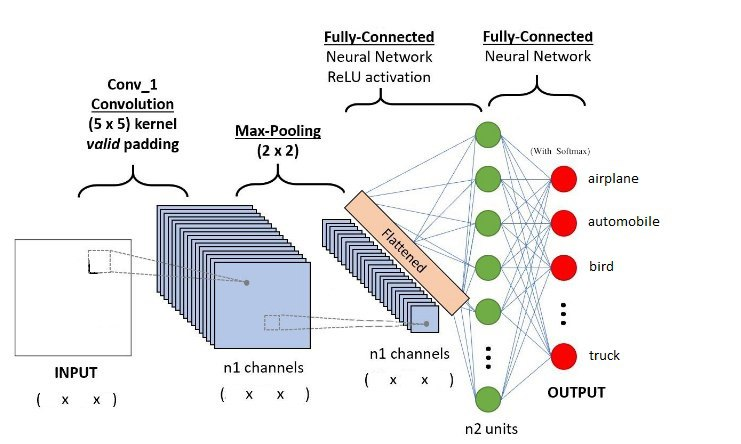

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What are the values for n1 and n2?
- What is the number of parameters for conv_1?

**Your answers here**
1. 32x32x3
2. 28x28x32. 

3. After max pooling, it is 14x14x32

4. n1 = 32, n2 = 14x14x32= 6272

5. 5x5x3x32+32   : the extra + 32 is for the bias 

In [ ]:
# TODO define model

class convnet(nn.Module):
  def __init__(self, img_width, num_in_channels, num_classes):
    super(convnet, self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(num_in_channels,32,5),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU())

    self.linear_layers = nn.Sequential(nn.Linear(14*14*32,512),
        nn.ReLU(),
        nn.Linear(512,num_classes)
        )
  def forward(self,x):
    x = self.conv_layers(x)
    x = x.view(-1, 14*14*32)
    x = self.linear_layers(x)

    return x




In [ ]:
model = convnet(32,3,10)
print (model)

convnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6272, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

In [ ]:
lr=0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 10

model.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader, early_stopper=False, verbose=False)
#train(dataloader, optimizer, model, loss_fn, device, master_bar)

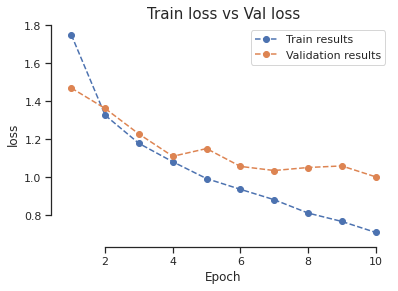

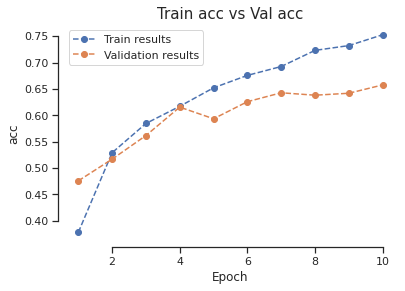

In [ ]:
plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

In [ ]:
lr=0.001
lr_policy = 'None'
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1, last_epoch=-1, verbose=False)
num_epochs = 20

model.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader,'None',scheduler, early_stopper=False, verbose=False)

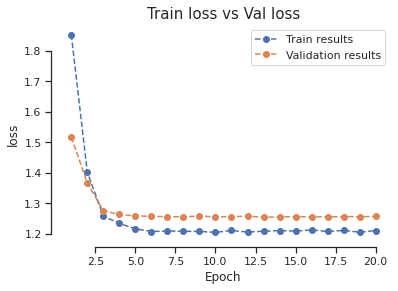

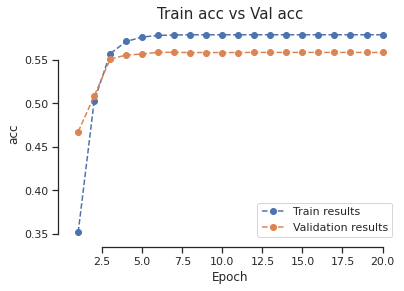

In [ ]:
plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

#### **TODO**
Compare results to MLP. What can you observe?

**Your answers here**

In [ ]:
path_addr = r"/content/drive/My Drive/conv_check_point.pt"
torch.save (model.state_dict(), path_addr)

In [ ]:
path_addr = r"/content/drive/My Drive/conv_check_point.pt"
model2 = convnet(32,3,10)
model2.load_state_dict(torch.load(path_addr))

<All keys matched successfully>

In [ ]:
loss_fn = nn.CrossEntropyLoss()
model2.to(device)
val_losses, val_accuracy, conf_matrix = validate(valloader,model2,loss_fn,device,master_bar = None)

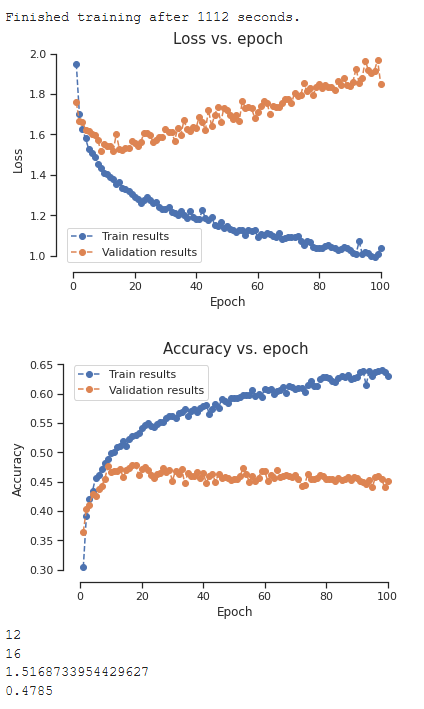

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 678 seconds.


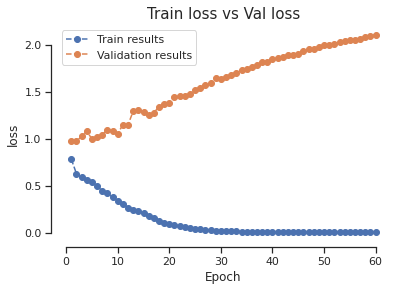

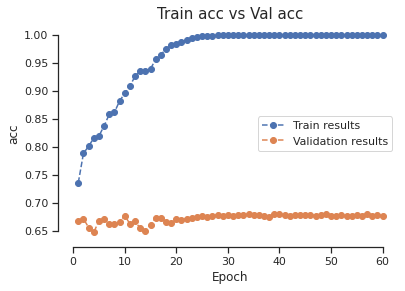

In [ ]:
# TODO train and plot

lr=0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 60

model.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

1. A simple model with less number of layers, therefore not many feature maps could be derived.

2. Increasing the number of layers could be improve the model and enable the model to learn better features from the images

**Your answers here**

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

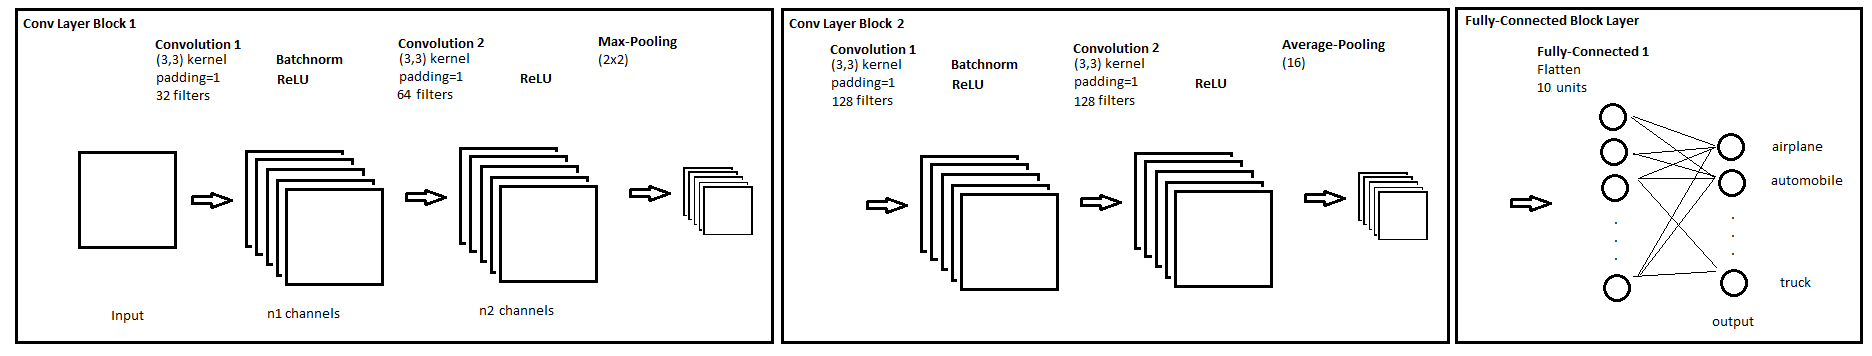

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**

1. the input to te next layer is padded with zeros of a specified length along rows and columns. same and valid.

2. Padding= 1 means the input is padded with 1 row and column of zeros n all sides.

3. after conv_1 = 32x32x64
4. after conv_2 = 16x16x128
5. 5x5
6. 128
7. 3x3x3x32+32 + 3x3x32x64 + 64

In [ ]:
#TODO define model 2

class big_convnet(nn.Module):
  def __init__(self, img_width, num_in_channels, num_classes):
    super(big_convnet, self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(num_in_channels,32,3,stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,64,3,stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64,128,3,stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,3,stride=1, padding=1),
        nn.ReLU(),
        nn.AvgPool2d(16))

    self.linear_layers = nn.Sequential(nn.Linear(1*1*128,num_classes)
        )
  def forward(self,x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)

    return x


In [ ]:
model3= big_convnet(32,3,10)

print (model3)

big_convnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): AvgPool2d(kernel_size=16, stride=16, padding=0)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

In [ ]:
# TODO train and plot

# TODO train and plot

lr=0.001
lr_policy = 'None'
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1, last_epoch=-1, verbose=False)
num_epochs = 20

model3.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model3, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader,'None',scheduler, early_stopper=False, verbose=False)

Finished training after 301 seconds.


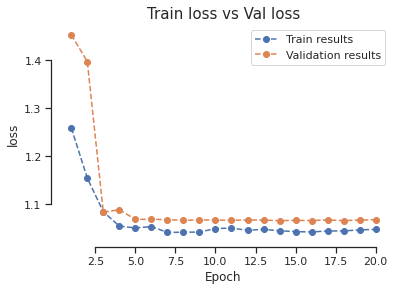

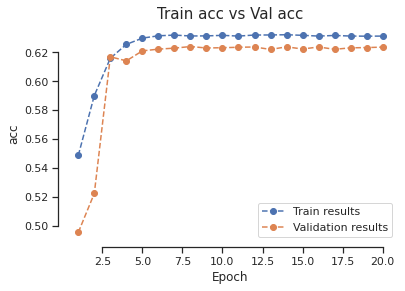

In [ ]:
plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

In the Below cell, I am defining the previously asked simple convnet structure in multiple parts to observe the dimensions after the forward pass 

In [ ]:
class conv_testnet(nn.Module):
  def __init__(self, img_width, num_in_channels, num_classes):
    super(conv_testnet, self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(num_in_channels,32,5))
    
    self.pool_layer = nn.Sequential(
        nn.MaxPool2d(kernel_size=2)
        )
    
    self.act_layer = nn.Sequential(nn.ReLU())
        

    self.linear_layers = nn.Sequential(nn.Linear(14*14*32,512),
        nn.ReLU(),
        nn.Linear(512,num_classes)
        )
  def forward(self,x):
    x = self.conv_layers(x)
    print (x.size())
    x = self.pool_layer(x)
    print (x.size())

    x = self.act_layer(x)
    print (x.size())

    x = x.view(-1, 14*14*32)
    x = self.linear_layers(x)

    return x


In [ ]:

net = conv_testnet(32,3,10)
lr=0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
num_epochs = 1

net.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(net, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

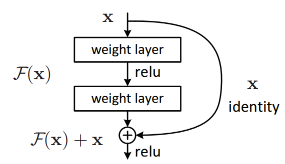

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**

1. The problem of vanishing gradients
2. Because it contains residual blocks that directly connect froman input to the block with the final layer of that block.
3. When the number of layers are many/ when it is very deep network

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model; the class contains the following methods:
    - init
    - make_layer
    - forward
- train the model
- plot results

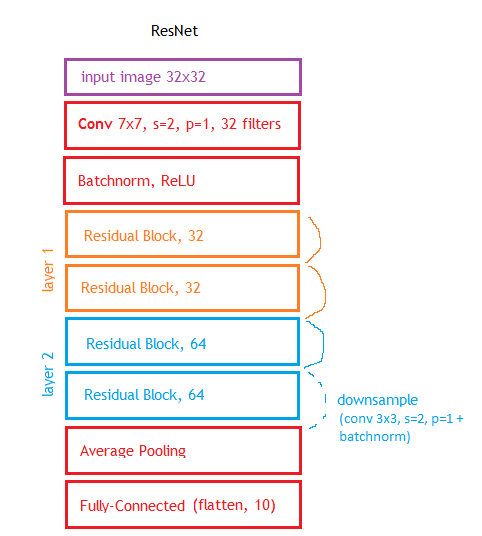
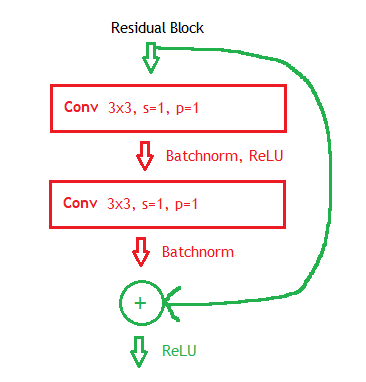

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    '''
        Conv--> Batchnorm-->ReLu-->Conv-->Batchnorm--> 
        Only downsample if needed
    '''
    def __init__(self, in_channels, out_channels, stride, downsample=None):
        super(ResidualBlock, self).__init__()
        # TODO
        if downsample:
          self.stride = 2
        else:
          self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        #print ('in_channels: ', in_channels)
        #print ('out_channels: ', out_channels)

        self.rb_layers1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=3,stride=self.stride,padding=1,bias=False)
        self.rb_layers2 = nn.BatchNorm2d(out_channels)

        self.new_in_channels = out_channels

        

        #self.rb_layers3 = F.relu()
        self.rb_layers4 = nn.Conv2d(in_channels=self.new_in_channels, out_channels=out_channels,kernel_size=3,stride=self.stride,padding=1,bias=False)
        self.rb_layers5 = nn.BatchNorm2d(out_channels)
        if self.in_channels != self.out_channels:
          self.rb_layers6 = nn.Conv2d(in_channels=out_channels, out_channels=in_channels,kernel_size=1,stride=1,padding=0,bias=False)

        
       
    def forward(self, x):
        # TODO
        y = self.rb_layers1(x)
        y = F.relu(self.rb_layers2(y))
        
        y = self.rb_layers4(y)
        y = self.rb_layers5(y)
        if y.shape[1]!=x.shape[1]:
          y = self.rb_layers6(y)

        #y = self.rb_layers5(y)
        out = F.relu(y+x)

        #print (out.shape)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        # TODO

        self.init_in_channels = 32
        self.init_out_channels= 32

        #self.res_layers = [0]*layers
        

        #block_dict = {}
        self.next_init_channels = []

        self.init_layers = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=32,kernel_size=7,stride=2,padding=1),
                                         nn.BatchNorm2d(32))
                                         
        

        self.layer1 = self.make_layer(block=0, out_channels=32, blocks=2, stride=1)


        self.layer2 = self.make_layer(block=1, out_channels=32, blocks=2, stride=1)

        self.layer3 = self.make_layer(block=0, out_channels=64, blocks=2, stride=1)

        self.layer4 = self.make_layer(block=1, out_channels=64, blocks=2, stride=1)

        self.layer5 = nn.AdaptiveAvgPool2d(output_size=6)

        self.layer6 = nn.Linear(6*6*32,10)


        
    def make_layer(self, block, out_channels, blocks, stride, padding=0):
        # TODO
        
        self.blocks = blocks
        self.block = block
        #block_dict = {}
      
        if self.block == 0:
          self.res_block = []
          self.in_channels = self.init_in_channels
          self.out_channels = self.init_out_channels

          #print ('in channels at block 0',self.in_channels)
          #print ('out channles at block 0',self.out_channels)
          self.res_block.append(ResidualBlock(self.in_channels, out_channels, stride=stride, downsample=None))
          self.next_init_channels.append(self.in_channels)
          self.next_init_channels.append(ResidualBlock(self.in_channels, out_channels, stride=stride, downsample=None).out_channels)
  
        elif self.block > 0 and self.block <= blocks :
          self.in_channels = self.next_init_channels[block]
          self.next_init_channels.append(ResidualBlock(self.in_channels, out_channels, stride=stride, downsample=None).out_channels)
          self.res_block.append(ResidualBlock(self.in_channels, out_channels, stride=1, downsample=None))

        interim_layers = nn.Sequential(*self.res_block)

        return interim_layers

  
    def forward(self, x):
        # TODO
        x =  self.init_layers(x)
        x =  F.relu(x)
        x =  self.layer1(x)
        #print ('after layer 1:', x.shape )
        x =  self.layer2(x)
        #print ('after layer 2:', x.shape )
        x =  self.layer3(x)
        x =  self.layer4(x)
        x =  self.layer5(x)
        y = x.view(-1,6*6*32)
        z =  self.layer6(y)

     
        return z

In [ ]:
resnet_model = ResNet()

#print (resnet_model)

Finished training after 922 seconds.


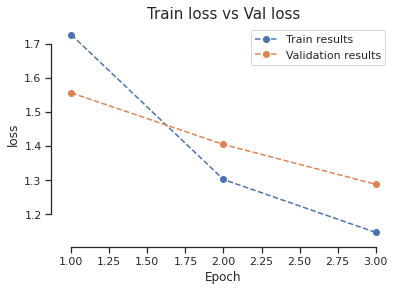

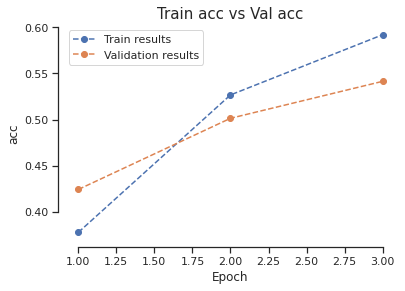

In [ ]:
# TODO train and plot

lr=0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=lr)
num_epochs = 3

resnet_model.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(resnet_model, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

In [ ]:
#val acc after 3 epochs
np.max(val_accs)

0.5414

In [ ]:
np.max(val_accs)

0.6992

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.

Finished training after 1303 seconds.


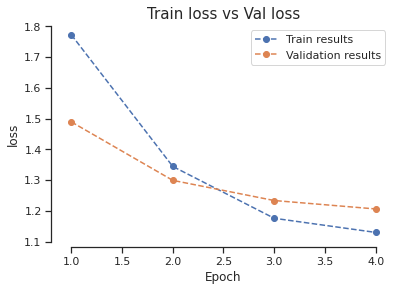

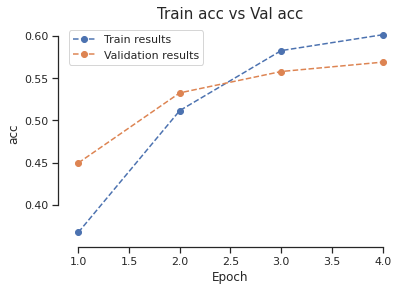

In [ ]:
lr=0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1, last_epoch=-1, verbose=False)
lr_policy = 'other'
num_epochs = 4

resnet_model.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(resnet_model, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader,lr_policy, scheduler, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

Step size of 1 with a higher gamma gives a better accuracy in the same number of epochs. i.e., if the learning rate increases slowly (in very small steps), it takes more epochs to attain high accuracy, wheres a larger learning rate attains a higher accuracy in the same num of epochs.

**Your answers here**

Finished training after 2946 seconds.


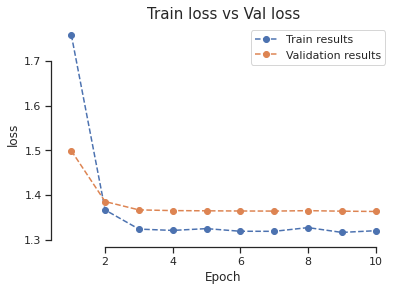

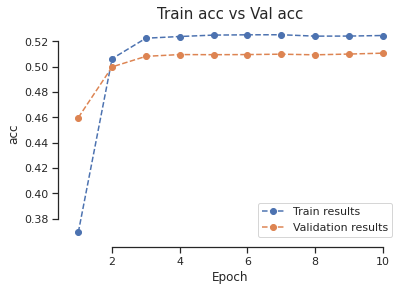

In [ ]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

lr=0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1, last_epoch=-1, verbose=False)
lr_policy = 'other'
num_epochs = 10

resnet_model.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(resnet_model, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader,lr_policy, scheduler, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

In [ ]:
# TODO train and plot with step size 1, gamma 0.1
#done in the cell above

Finished training after 2977 seconds.


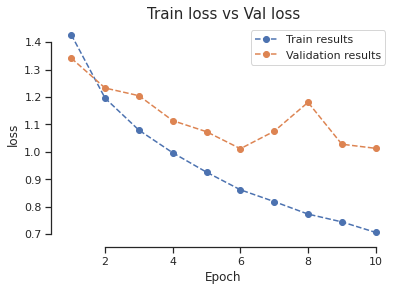

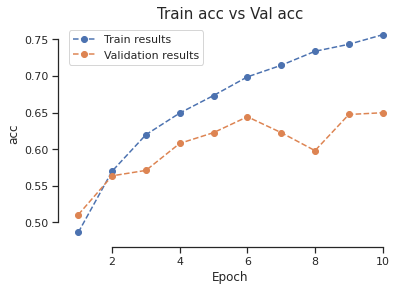

In [ ]:
# TODO train and plot with step size 1, gamma 0.9

lr=0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9, last_epoch=-1, verbose=False)
lr_policy = 'other'
num_epochs = 10

resnet_model.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(resnet_model, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader,lr_policy, scheduler, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

#### **TODO** 

Use the learning rate schedule as described in the ResNet paper (https://arxiv.org/pdf/1512.03385.pdf). Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

Finished training after 1324 seconds.


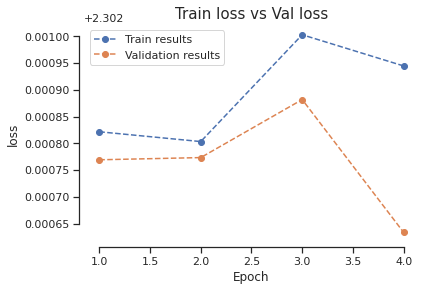

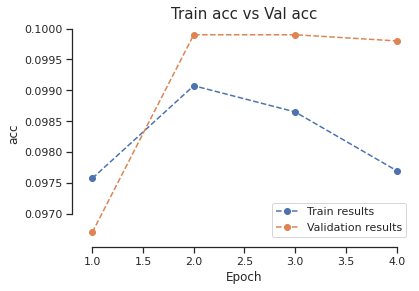

In [ ]:
# TODO train and plot with scheduling, optimizer, lr as in the paper.

lr=0.1
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=lr, momentum=0.9,weight_decay=0.0001)
lr_policy = 'R_on_plateau'
if lr_policy== 'R_on_plateau':
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
num_epochs = 4

resnet_model.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(resnet_model, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader, lr_policy, scheduler, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [ ]:
# TODO train and plot
lr=0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1, verbose=False)
num_epochs = 4

resnet_model.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(resnet_model, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader, scheduler, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**


Computaion time was a lot lower when the model was fine-tuned 

In [ ]:
# TODO do transfer learning with resnet on cifar10

model_pret = torchvision.models.resnet18(pretrained=True)



In [ ]:
print (model_pret)

In [ ]:
for param in model_pret.parameters():
    param.requires_grad = False

model_pret.fc = nn.Linear(512,10)

#update_params = []
#for name,p in model_pret.named_parameters():
#  if p.requires_grad== True:
#    update_params.append(p)




In [ ]:
lr=0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pret.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1, verbose=False)
num_epochs = 10

model_pret.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_pret, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader, scheduler, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)


In [ ]:
#validate
loss_fn = nn.CrossEntropyLoss()
model_pret.to(device)
val_losses, val_accuracy, conf_matrix = validate(valloader,model_pret,loss_fn,device,master_bar = None)


In [ ]:
print (val_losses)
print (val_accuracy)

2.4279403686523438
0.1025


Finished training after 368 seconds.


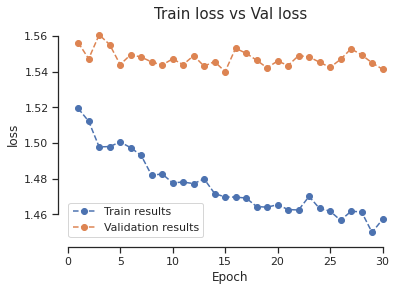

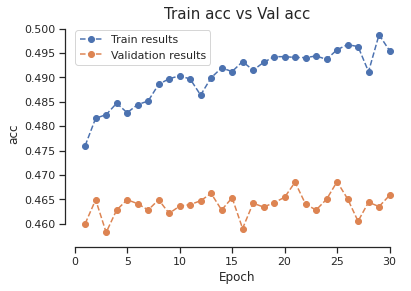

In [ ]:
lr=0.001
lr_policy = 'None'
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(update_params, lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1, verbose=False)

num_epochs = 30

model_pret.to(device)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_pret, optimizer, loss_function, device, num_epochs, 
             trainloader, valloader, lr_policy, scheduler, early_stopper=False, verbose=False)

plot('Train loss vs Val loss', 'loss', train_losses,val_losses)
plot ('Train acc vs Val acc', 'acc', train_accs, val_accs)